In [1]:
import pandas as pd
from cyvcf2 import VCF
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from collections import defaultdict
import csv
import re
from functools import reduce
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def CheckMI(sample_gt, mother_gt, father_gt): # check GT level MI
    if sample_gt[0] in mother_gt[0:2] and sample_gt[1] in father_gt[0:2]:
        return True
    if sample_gt[1] in mother_gt[0:2] and sample_gt[0] in father_gt[0:2]:
        return True
    return False

def CheckMIlen(sample_gt, mother_gt, father_gt, buffer): # check length level MI allowing for buffer difference
    mother_approx = []
    for x in mother_gt:
        mother_approx.extend([l for l in range(len(x) - buffer,len(x) + buffer+1)])
    father_approx = []
    for x in father_gt:
        father_approx.extend([l for l in range(len(x) - buffer,len(x) + buffer+1)])
    if len(sample_gt[0]) in list(set(mother_approx)) and len(sample_gt[1]) in list(set(father_approx)):
        return True
    if len(sample_gt[1]) in list(set(mother_approx)) and len(sample_gt[0]) in list(set(father_approx)):
        return True
    return False

def IsRef(gt, REF):
    return gt[0]==REF and gt[1]==REF

In [3]:
####### Read HipSTR-long output on HG002, HG003, HG004 and compute GT MI and length MI #######
MI_list = []
ref_cnt = 0
missing_call = 0
for chrom in range(1,23):
    print(chrom)
    vcf = VCF(f"calls/trio_hipstr_hg38_chr{chrom}_apr23.vcf.gz")
    samples = vcf.samples
    family = ['HG002', 'HG003', 'HG004']
    for variant in vcf:
        if len(variant.ALT) == 0: # If there is no alt allele here
            ref_cnt += 1
            continue
        if variant.CHROM == "chrX" or variant.CHROM == "chrY":
            break
        sample_index = samples.index(family[0])
        mother_index = samples.index(family[1])
        father_index = samples.index(family[2])
        fam_indices = [sample_index, mother_index, father_index]
        sample_GT = variant.gt_bases[sample_index].split("|")
        mother_GT = variant.gt_bases[mother_index].split("|")
        father_GT = variant.gt_bases[father_index].split("|")
        if "." in sample_GT[0] or "." in mother_GT[0] or "." in father_GT[0]: # No call
            missing_call += 1
            continue
        if IsRef(sample_GT, variant.REF) and IsRef(mother_GT, variant.REF) and IsRef(father_GT, variant.REF): # all homozygous ref
            ref_cnt += 1
            continue
        gbs=("%s,%s,%s"%(variant.format("GB")[sample_index],
                          variant.format("GB")[mother_index],
                          variant.format("GB")[father_index]))
        MI_val = CheckMI(sample_GT, mother_GT, father_GT)
        MI_val_len = CheckMIlen(sample_GT, mother_GT, father_GT,1)
        min_score_gt = np.min([variant.format('Q')[ind] for ind in fam_indices])
        MI_list.append([variant.CHROM, variant.POS, variant.ID, variant.INFO["PERIOD"], family[0], \
                 MI_val, MI_val_len, min_score_gt, gbs])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [4]:
data = pd.DataFrame(MI_list, 
    columns=["chrom","pos", "ID", "period","sample","MI","MI_len", "Score","gbs"])
print(len(data), ref_cnt, missing_call, len(data[data['MI'] == True]) / len(data))
for i in range(1,11):
    pdata = data[data['period'] == i]
    print(i, len(pdata), round(len(pdata[pdata['MI'] == True]) / len(pdata)*100,2), round(len(pdata[pdata['MI_len'] == True]) / len(pdata)*100,2))
pdata = data[data['period'] > 10]
print("11 and more", round(len(pdata[pdata['MI'] == True]) / len(pdata)*100,2), round(len(pdata[pdata['MI_len'] == True]) / len(pdata)*100,2))    

698675 204395 885 0.8560947507782588
1 342927 78.37 99.47
2 99468 93.98 96.18
3 18684 95.87 99.16
4 54833 95.61 98.63
5 18420 93.83 99.4
6 15079 91.96 98.98
7 9635 89.69 99.45
8 11888 90.7 99.21
9 8760 87.92 99.24
10 10097 89.34 99.23
11 and more 90.26 98.7


In [8]:
data_above_90 = data[(data['Score'] > 0.95)]
display(data_above_90)
print(len(data))
len(data_above_90[data_above_90['MI'] == True]) / len(data_above_90)

,chrom,pos,ID,period,sample,MI,MI_len,Score,gbs
0,chr1,20798,chr1_20798_20893_GAGCCACCACAGAAAACA,18,HG002,True,True,1.0,"0|1,0|1,0|1"
1,chr1,29714,chr1_29714_29822_CCCCG,5,HG002,True,True,1.0,"0|0,0|0,0|0"
2,chr1,30824,chr1_30824_30989_TC,2,HG002,True,True,1.0,"-26|2,-26|2,-26|-5"
5,chr1,98969,chr1_98969_99141_CTTTTTTTTTTTTTTTTTTTTTTTTCTTT,29,HG002,True,True,1.0,"1|4,1|4,0|4"
6,chr1,102079,chr1_102079_102182_AATAAACTAGAAAACAGAAAC,21,HG002,True,True,1.0,"0|0,0|0,0|0"
...,...,...,...,...,...,...,...,...,...
702098,chr22,50786100,chr22_50786100_50786420_GTTAGGGTTAGGGTTAGGGTTA...,31,HG002,True,True,1.0,"0|-13,-13|0,0|-13"
702099,chr22,50787891,chr22_50787891_50788000_AGAT,4,HG002,True,True,1.0,"0|0,0|0,0|0"
702100,chr22,50790941,chr22_50790941_50791181_AGGGTC,6,HG002,True,True,1.0,"0|3,3|3,0|3"
702101,chr22,50796685,chr22_50796685_50796788_AC,2,HG002,True,True,1.0,"4|-2,-2|0,4|-2"


702103


0.8859865167974567

In [5]:
###### TRGT MI analysis #####

def check_MI_trgt(ref, sample, mother, father):
    if pd.isnull(father) or pd.isnull(mother) or pd.isnull(sample):
        return 'no_call'
    sample = sample.split("/")
    mother = mother.split("/")
    father = father.split("/")
    if sample[0] == "." or mother[0] == "." or father[0] == ".":
        return 'no_call'
    if sample[0] == ref and sample[1] == ref and mother[0] == ref and mother[1] == ref and father[0] == ref and father[1] == ref:
        return 'ref'
    if sample[0] in mother and sample[1] in father:
        return True
    if sample[1] in mother and sample[0] in father:
        return True
    return False

def extract_trgt_period(motif):
    motif = motif.split(",")
    period = list(set([len(m) for m in motif]))
    if len(period) == 1:
        return period[0]
    else:
        return "ambigious"
    
dfs = []
for sample in ['HG002', 'HG003', 'HG004']:
    print(sample)
    vcf = VCF(f"../../TRGT/{sample}_wg_trgt_hg38.sorted.vcf.gz")
    sample_list = []
    for variant in vcf:
        if variant.CHROM == "chrX" or variant.CHROM == "chrY":
            break
        AL = variant.format("AL")[0]
        GB = [A - len(variant.REF) for A in AL]
        sample_list.append([variant.CHROM, variant.POS, variant.INFO['MOTIFS'],
                            variant.REF, variant.INFO['TRID'], variant.gt_bases[0], GB])
    sample_df = pd.DataFrame(sample_list, columns = ['CHROM', 'POS', 'MOTIFS', 'REF', 'ID', f'GT_{sample}', f'GB_{sample}'])
    dfs.append(sample_df)
    
df_trio = reduce(lambda  left,right: pd.merge(left,right,on=['CHROM', 'POS','ID', 'REF', 'MOTIFS'],
                                            how='outer'), dfs)
df_trio['MI'] = df_trio.apply(lambda row: check_MI_trgt(row['REF'], row['GT_HG002'], row['GT_HG003'], row['GT_HG004']), axis =1)
df_trio['period'] = df_trio.apply(lambda row: extract_trgt_period(row['MOTIFS']), axis =1)

not_nan = df_trio[(df_trio['MI'] != "ref") & (df_trio['MI'] != "no_call")]
print(len(not_nan[not_nan['MI'] == True]) / len(not_nan))


HG002
HG003
HG004
0.7879459490841534


In [6]:
trgt_MI = {}
for period in range(1,8):
    if period < 7:
        pdata = not_nan[not_nan["period"]==period].copy()
    else: 
        pdata = not_nan[not_nan["period"]>=period].copy()
    trgt_MI[period] = len(pdata[pdata['MI'] == True]) / len(pdata)
trgt_MI

{1: 0.7391388049150988,
 2: 0.8490080342688212,
 3: 0.9010447680398419,
 4: 0.8683122301105175,
 5: 0.8853717821235223,
 6: 0.8617617279784002,
 7: 0.793338364979741}

1 343407
[0.785737230966913, 0.7934196658954076, 0.7989984720357803, 0.8066966896900001, 0.8159574608976651]
2 100235
[0.9410929595488993, 0.9442197811041365, 0.9453075315708186, 0.9467650132402625, 0.9497369121470836]
3 18898
[0.9589229872263741, 0.96141342002878, 0.962620320855615, 0.963819149508091, 0.965616200996318]
4 55276
[0.9565264664842433, 0.9587987681542358, 0.9603263155969344, 0.9621579876434245, 0.9643531721047368]
5 18576
[0.9388349514563107, 0.9414743031358885, 0.9425318811230913, 0.9450022065313327, 0.9481498018641513]
6 15180
[0.9214625131995776, 0.925564613123079, 0.9274855374680478, 0.930521597392013, 0.9336678581248281]
7 150531
[0.9033317347400954, 0.9085115298315807, 0.9111320201544997, 0.9148997866626163, 0.919309024344057]


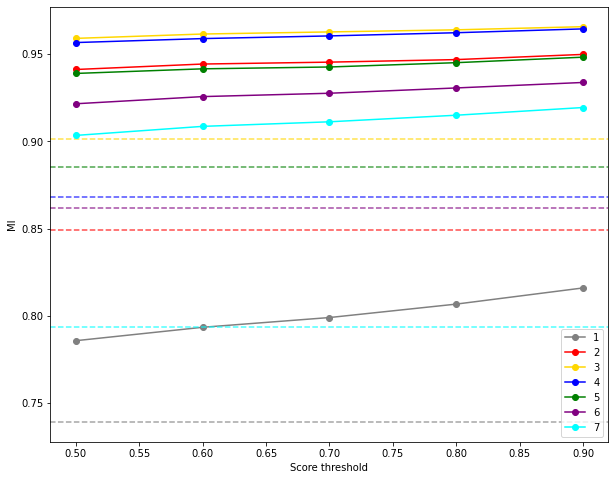

In [20]:
percolors = ["gray","red","gold","blue","green","purple","aqua","lightgreen","lightblue","orange","pink"]

def PlotByScore(data, scorecol, percolors):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    for period in range(1, 8):
        if period < 7:
            pdata = data[data["period"]==period].copy()
        else: pdata = data[data["period"]>=period].copy()
        print(period,len(pdata))
        mis = []
        ns = []
        thresh = np.arange(0.5, 1.0, 0.1)
        for t in thresh:
            mis.append(np.mean(pdata[pdata[scorecol]>=t]["MI"]))
            ns.append(pdata[pdata[scorecol]>=t].shape[0])
        ax.plot(thresh, mis, marker="o", color=percolors[period-1], label=period)
        ax.axhline(y=trgt_MI[period], color=percolors[period-1], linestyle='--',alpha=0.7)
        ax.plot()
        print(mis)
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("MI")
    ax.legend(loc="lower right")
    #plt.savefig("Score_MI.pdf", dpi=1200)
    
PlotByScore(data, "Score", percolors)